# Analysis of CheXpert Response, Feature & Attention KD with high capacity teacher (ResNet101)

In [2]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import math
import re
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 250

### Teacher: 
- Resnet101, Seed 46

### Students:
No Female:
- Resnet18: Seeds 44, 46
- Resnet34: Seeds 45, 46

No Old:
- Resnet18: Seeds 42, 46
- Resnet34: Seeds 42, 45

No White:
- Resnet18: Seeds 42, 46
- Resnet34: Seeds 44, 46

## Read Data

In [3]:
def read_data(path, teacher_id=None):
    test_data = []
    for folder in os.scandir(path):
        if teacher_id is not None:
            if folder.is_dir() and teacher_id in folder.name:
                # Perform operations on the folder
                file_path = path + folder.name
                if os.path.exists(file_path + '/test.csv'):
                    df_tmp = pd.read_csv(file_path + '/test.csv')
                    test_data.append(df_tmp)
        else:
            if folder.is_dir():
                # Perform operations on the folder
                file_path = path + folder.name
                if os.path.exists(file_path + '/test.csv'):
                    df_tmp = pd.read_csv(file_path + '/test.csv')
                    test_data.append(df_tmp)

    df = pd.concat(test_data)
    df['auc_gap_relative'] = df['auc_gap'] / df['auc']
    df['age_auc'] = (df['age_auc_group_0'] + df['age_auc_group_1']) / 2
    df['sex_auc'] = (df['sex_auc_group_0'] + df['sex_auc_group_1']) / 2
    df['race_auc'] = (df['race_auc_group_0'] + df['race_auc_group_1']) / 2
    df['age_auc_gap'] = abs(df['age_auc_group_0'] - df['age_auc_group_1'])
    df['sex_auc_gap'] = abs(df['sex_auc_group_0'] - df['sex_auc_group_1'])
    df['race_auc_gap'] = abs(df['race_auc_group_0'] - df['race_auc_group_1'])
    df['avg_auc_gap'] = (df['age_auc_gap'] + df['sex_auc_gap'] + df['race_auc_gap']) / 3
    df['age_auc_gap_relative'] = df['age_auc_gap'] / df['auc']
    df['sex_auc_gap_relative'] = df['sex_auc_gap'] / df['auc']
    df['race_auc_gap_relative'] = df['race_auc_gap'] / df['auc']
    df['avg_auc_gap_relative'] = df['avg_auc_gap'] / df['auc']
    return df

original_df = read_data('../../results/chexpert/resnet/')
print(original_df.shape)

kd_normal_capacity_no_female_df = read_data('../../results/chexpert_no_female/kd/', 'r34-sam1-s43')
kd_normal_capacity_no_old_df = read_data('../../results/chexpert_no_old/kd/', 'r34-sam1-s43')
kd_normal_capacity_no_white_df = read_data('../../results/chexpert_no_white/kd/', 'r34-sam1-s43')
print(kd_normal_capacity_no_female_df.shape, kd_normal_capacity_no_old_df.shape, kd_normal_capacity_no_white_df.shape)

kd_no_female_df = read_data('../../results/chexpert_no_female/kd/', 'r101-sam1-s46')
kd_no_old_df = read_data('../../results/chexpert_no_old/kd/', 'r101-sam1-s46')
kd_no_white_df = read_data('../../results/chexpert_no_white/kd/', 'r101-sam1-s46')
print(kd_no_female_df.shape, kd_no_old_df.shape, kd_no_white_df.shape)

feature_no_female_df = read_data('../../results/chexpert_no_female/kd-feature_rgb/', 'r101-sam1-s46')
feature_no_old_df = read_data('../../results/chexpert_no_old/kd-feature_rgb/', 'r101-sam1-s46')
feature_no_white_df = read_data('../../results/chexpert_no_white/kd-feature_rgb/', 'r101-sam1-s46')
print(feature_no_female_df.shape, feature_no_old_df.shape, feature_no_white_df.shape)

attention_no_female_df = read_data('../../results/chexpert_no_female/attention_kd/', 'r101-sam1-s46')
attention_no_old_df = read_data('../../results/chexpert_no_old/attention_kd/', 'r101-sam1-s46')
attention_no_white_df = read_data('../../results/chexpert_no_white/attention_kd/', 'r101-sam1-s46')
print(attention_no_female_df.shape, attention_no_old_df.shape, attention_no_white_df.shape)

no_female_df = read_data('../../results/chexpert_no_female/resnet/')
no_female_df = no_female_df[no_female_df['model_name'].isin(['resnet18', 'resnet34'])]

no_old_df = read_data('../../results/chexpert_no_old/resnet/')
no_old_df = no_old_df[no_old_df['model_name'].isin(['resnet18', 'resnet34'])]

no_white_df = read_data('../../results/chexpert_no_white/resnet/')
no_white_df = no_white_df[no_white_df['model_name'].isin(['resnet18', 'resnet34'])]

print(no_female_df.shape, no_old_df.shape, no_white_df.shape)

(60, 93)
(10, 94) (10, 94) (10, 94)
(10, 94) (10, 94) (10, 94)
(10, 95) (10, 95) (10, 95)
(10, 95) (10, 95) (10, 95)
(10, 94) (10, 94) (10, 94)


## Overall Performance

In [5]:
def kd_overall_model_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        feature_df: pd.DataFrame,
        attention_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.2, 
        line_length=0.05,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])
    feature_df = feature_df.sort_values(by=['model_name'])
    attention_df = attention_df.sort_values(by=['model_name'])

    # Get teachers from resnet_df
    teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][metric]
                            
    # Set up graphical variables
    total_bars = 4
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(11, 7))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        model_scores = []

        # Get without KD
        scores = resnet_df[(resnet_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
        handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor='blue', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'Baseline: No KD' not in legend_labels:
            legend_handles.append(handle_no_kd)
            legend_labels.append('Baseline: No KD')

        # Get with KD
        scores = kd_df[(kd_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
        handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor='orange', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'With KD' not in legend_labels:
            legend_handles.append(handle_kd)
            legend_labels.append('With KD')


        # Get with Feature KD
        scores = feature_df[(feature_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_feature_kd = i - bar_group_width/2 + (2 + 0.5) * bar_width
        handle_feature_kd = ax.errorbar(x_pos_feature_kd, mean_score, yerr=std_error, marker='s', capsize=5, markersize=12, markerfacecolor='green', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'With Feature KD' not in legend_labels:
            legend_handles.append(handle_feature_kd)
            legend_labels.append('With Feature KD')


        # Get with Attention KD
        scores = attention_df[(attention_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_attention_kd = i - bar_group_width/2 + (3 + 0.5) * bar_width
        handle_attention_kd = ax.errorbar(x_pos_attention_kd, mean_score, yerr=std_error, marker='^', capsize=5, markersize=12, markerfacecolor='purple', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'With Attention KD' not in legend_labels:
            legend_handles.append(handle_attention_kd)
            legend_labels.append('With Attention KD')

        # Draw a dotted line between No KD and KD
        ax.plot([x_pos_no_kd, x_pos_kd, x_pos_feature_kd, x_pos_attention_kd], [model_scores[0], model_scores[1], model_scores[2], model_scores[3]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher = ax.axhline(y=teacher_performance[0], linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher)
    legend_labels.append('Teacher Performance')
    # Add text above the teacher performance line
    # ax.text(-0.45, teacher_performance[0], 'Teacher Performance', color='black', va='bottom')

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('AUC', fontsize=15) 
    # ax.set_xlabel('Model', fontsize=15)
    ax.xaxis.labelpad = 10
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')
    # Legend
    ax.legend(handles=legend_handles, labels=legend_labels, loc='lower right', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=18, y=0.98)

    # plt.show()

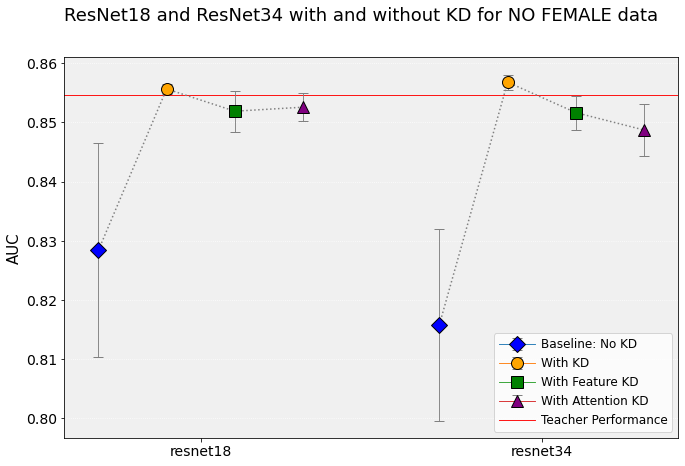

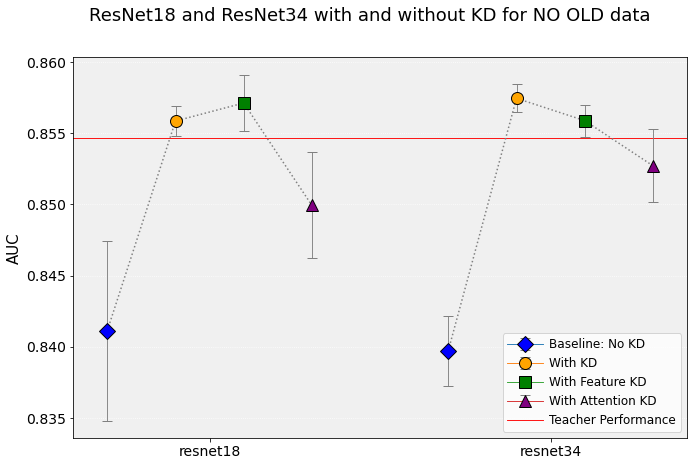

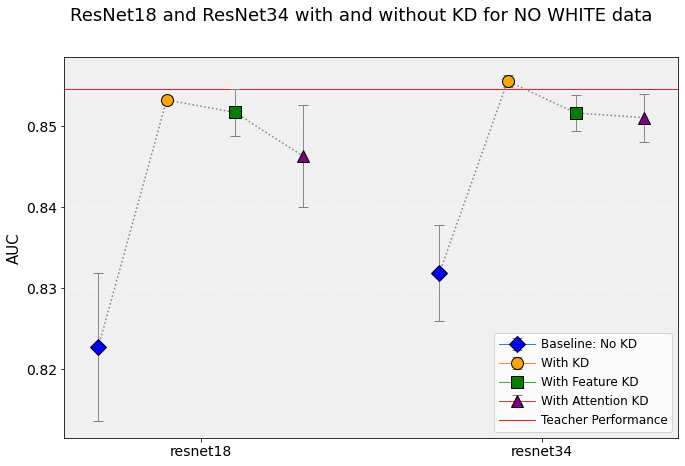

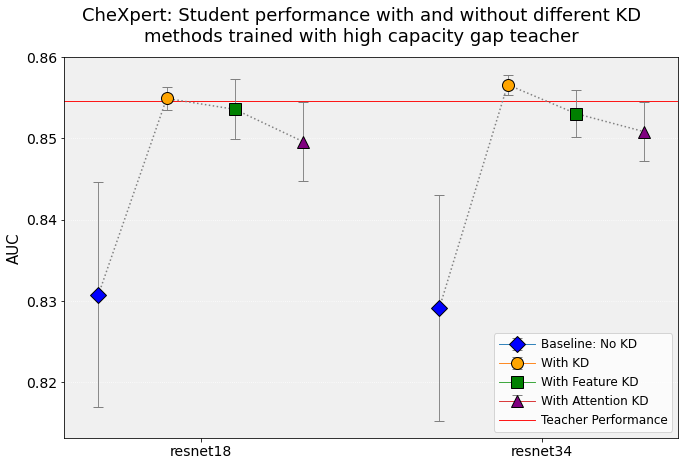

In [6]:
kd_overall_model_performance(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    attention_no_female_df,
    original_df,
    'r101-sam1-s46',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO FEMALE data',
)

kd_overall_model_performance(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    attention_no_old_df,
    original_df,
    'r101-sam1-s46',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO OLD data',
)

kd_overall_model_performance(
    no_white_df,
    kd_no_white_df,
    feature_no_white_df,
    attention_no_white_df,
    original_df,
    'r101-sam1-s46',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO WHITE data',
)

all_students_df = pd.concat([no_female_df, no_old_df, no_white_df])
all_students_kd_df = pd.concat([kd_no_female_df, kd_no_old_df, kd_no_white_df])
all_students_feature_df = pd.concat([feature_no_female_df, feature_no_old_df, feature_no_white_df])
all_students_attention_df = pd.concat([attention_no_female_df, attention_no_old_df, attention_no_white_df])

kd_overall_model_performance(
    all_students_df,
    all_students_kd_df,
    all_students_feature_df,
    all_students_attention_df,
    original_df,
    'r101-sam1-s46',
    'auc',
    title='CheXpert: Student performance with and without different KD\nmethods trained with high capacity gap teacher',
)

## Subgroup Disparities

In [7]:
experiment_colors = {
    "sex_no_kd": "#FFB6C1",
    "sex_kd": "#FF69B4",
    "sex_feature": "#800080",
    "sex_attention": "#4B0082",
    "age_no_kd": "#FFDFBA",
    "age_kd": "#FFA500",
    "age_feature": "#FF8C00",
    "age_attention": "#FF4500",
    "race_no_kd": "honeydew",
    "race_kd": "palegreen",
    "race_feature": "green",
    "race_attention": "darkgreen"
}


def kd_overall_model_subgroup_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        feature_df: pd.DataFrame,
        attention_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        subgroups: list[str],
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.2, 
        line_length=0.05,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])
    feature_df = feature_df.sort_values(by=['model_name'])
    attention_df = attention_df.sort_values(by=['model_name'])

    age_metric = 'age_' + metric
    sex_metric = 'sex_' + metric
    race_metric = 'race_' + metric

    # Get teachers from resnet_df
    age_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][age_metric][0]
    sex_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][sex_metric][0]
    race_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][race_metric][0]
                            
    # Set up graphical variables
    total_bars = 4
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        for j, subgroup in enumerate(subgroups):
            model_scores = []
            subgroup_metric = subgroup + "_" + metric


            # Get without KD
            scores = resnet_df[(resnet_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
            handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_no_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)
            if f'{subgroup.capitalize()} w/o KD' not in legend_labels:
                legend_handles.append(handle_no_kd)
                legend_labels.append(f'{subgroup.capitalize()} w/o KD')


            # Get with KD
            scores = kd_df[(kd_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
            handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)
            if f'{subgroup.capitalize()} w/ Response KD' not in legend_labels:
                legend_handles.append(handle_kd)
                legend_labels.append(f'{subgroup.capitalize()} w/ Response KD')


            # Get with Feature KD
            scores = feature_df[(feature_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_feature_kd = i - bar_group_width/2 + (2 + 0.5) * bar_width
            handle_feature_kd = ax.errorbar(x_pos_feature_kd, mean_score, yerr=std_error, marker='s', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_feature'], markeredgecolor='black', ecolor='gray', linewidth=0.9)
            if f'{subgroup.capitalize()} w/ Feature KD' not in legend_labels:
                legend_handles.append(handle_feature_kd)
                legend_labels.append(f'{subgroup.capitalize()} w/ Feature KD')


            # Get with Attention KD
            scores = attention_df[(attention_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_attention_kd = i - bar_group_width/2 + (3 + 0.5) * bar_width
            handle_attention_kd = ax.errorbar(x_pos_attention_kd, mean_score, yerr=std_error, marker='^', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_attention'], markeredgecolor='black', ecolor='gray', linewidth=0.9)
            if f'{subgroup.capitalize()} w/ Attention KD' not in legend_labels:
                legend_handles.append(handle_attention_kd)
                legend_labels.append(f'{subgroup.capitalize()} w/ Attention KD')

            # Draw a dotted line between No KD and KD
            ax.plot([x_pos_no_kd, x_pos_kd, x_pos_feature_kd, x_pos_attention_kd], [model_scores[0], model_scores[1], model_scores[2], model_scores[3]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher_age = ax.axhline(y=age_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher_age)
    legend_labels.append('Age Teacher')

    teacher_sex = ax.axhline(y=sex_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='violet')
    legend_handles.append(teacher_sex)
    legend_labels.append('Sex Teacher')

    teacher_race = ax.axhline(y=race_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='green')
    legend_handles.append(teacher_race)
    legend_labels.append('Race Teacher')

    # Set legend title
    legend = ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 14}, labelspacing=0.8)
    legend.set_title('Subgroup AUC Gap', prop={'size': 15})
    # legend's face color:
    legend.get_frame().set_facecolor('#F0F0F0')
    # legend's border color:
    legend.get_frame().set_edgecolor('black')
    # set legend's opacity
    legend.get_frame().set_alpha(1)

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=16)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel('Avg AUC Gap', fontsize=16) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')
    # Legend
    # ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=20, y=0.98)

    # plt.show()

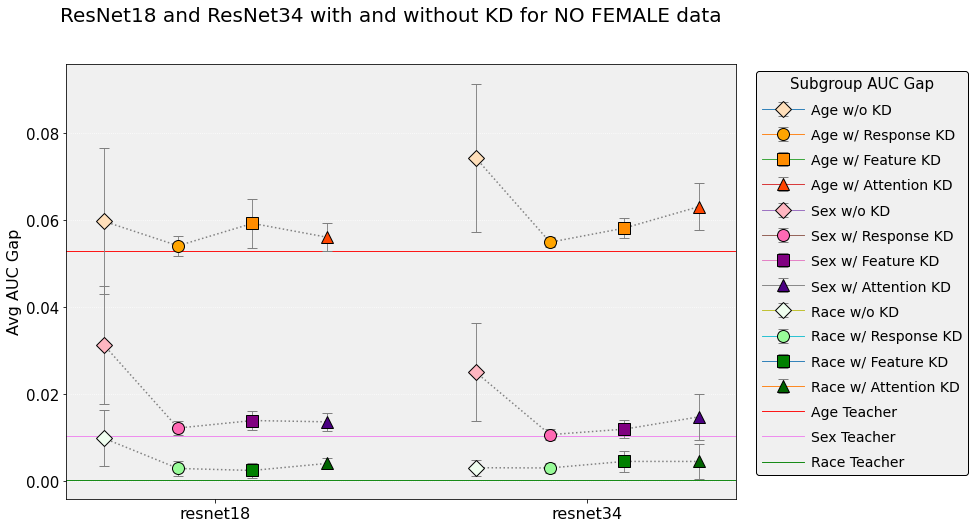

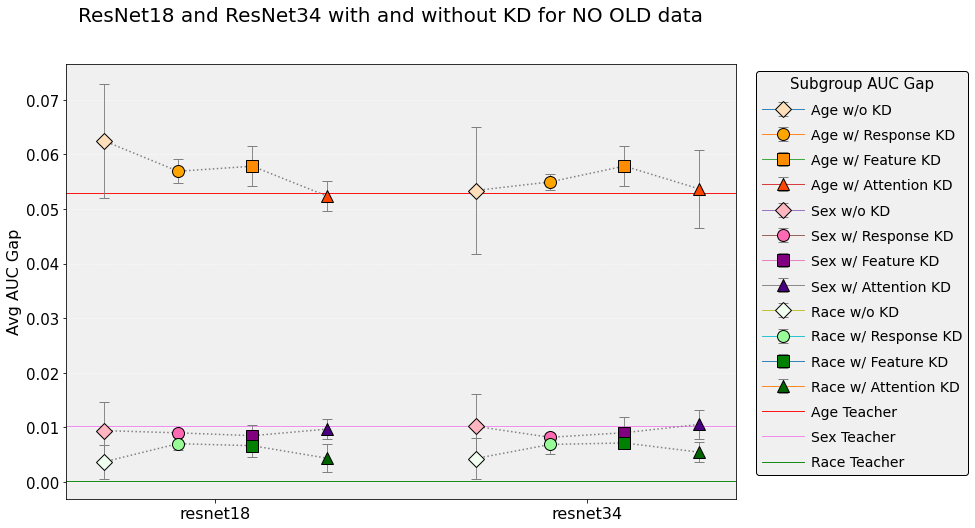

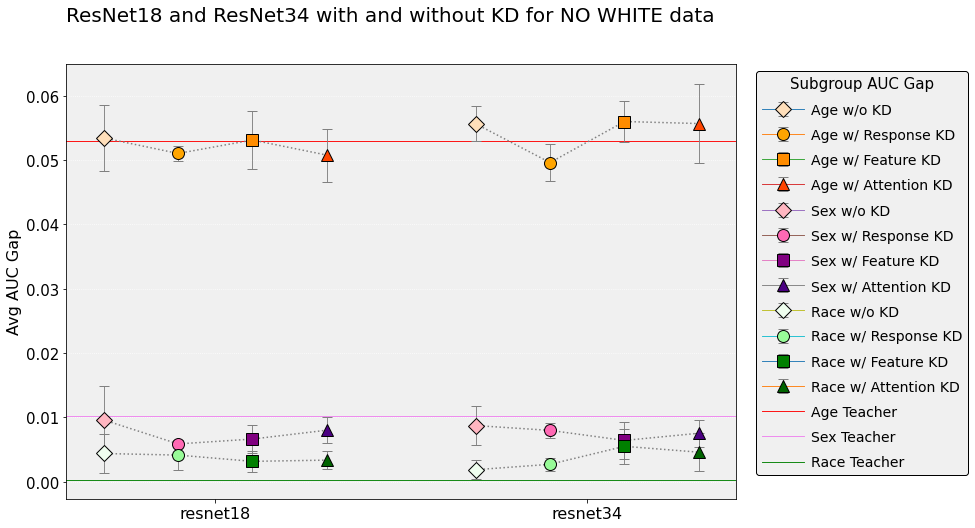

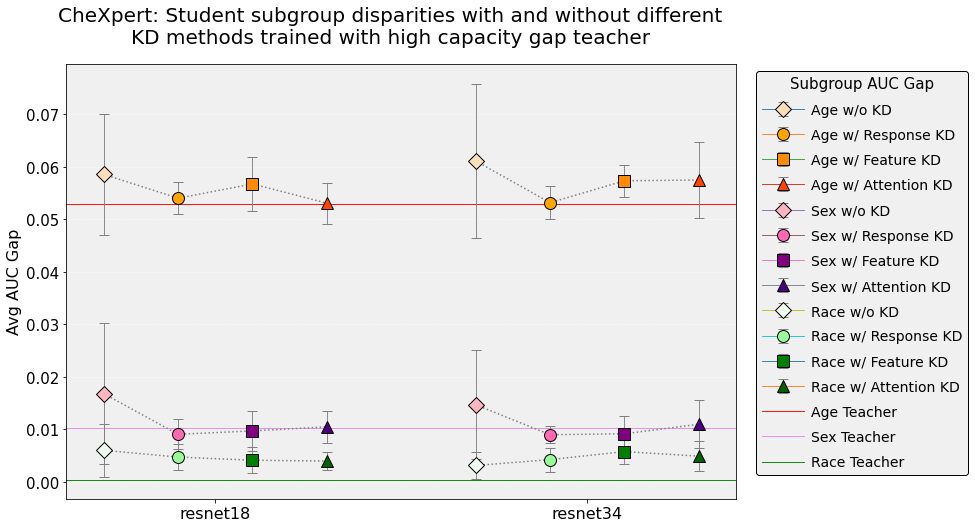

In [8]:
kd_overall_model_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    attention_no_female_df,
    original_df,
    ['age', 'sex', 'race'],
    'r101-sam1-s46',
    'auc_gap_relative',
    title='ResNet18 and ResNet34 with and without KD for NO FEMALE data',
)

kd_overall_model_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    attention_no_old_df,
    original_df,
    ['age', 'sex', 'race'],
    'r101-sam1-s46',
    'auc_gap_relative',
    title='ResNet18 and ResNet34 with and without KD for NO OLD data',
)

kd_overall_model_subgroup_performance(
    no_white_df,
    kd_no_white_df,
    feature_no_white_df,
    attention_no_white_df,
    original_df,
    ['age', 'sex', 'race'],
    'r101-sam1-s46',
    'auc_gap_relative',
    title='ResNet18 and ResNet34 with and without KD for NO WHITE data',
)

kd_overall_model_subgroup_performance(
    all_students_df,
    all_students_kd_df,
    all_students_feature_df,
    all_students_attention_df,
    original_df,
    ['age', 'sex', 'race'],
    'r101-sam1-s46',
    'auc_gap_relative',
    title='CheXpert: Student subgroup disparities with and without different\nKD methods trained with high capacity gap teacher',
)





## Subgroup Performance

In [9]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60 AUC',
    'age_auc_group_1': 'Age 60+ AUC',
    'sex_auc_group_0': 'Male AUC',
    'sex_auc_group_1': 'Female AUC',
    'race_auc_group_0': 'White AUC',
    'race_auc_group_1': 'Non-White AUC',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'race_auc_gap': 'Race AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
    'race_eq_odds': 'Race Eq. Odds',
}

def overall_radar_plot(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    feature_df: pd.DataFrame, 
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34
    title: str = 'title',
    is_performance: bool = True,
):
    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    student_baseline = resnet_df[resnet_df['model_name'] == student_model]
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')
    
    # get the average kd performance by model
    student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['teacher_id'] == teacher_id)]
    student_kd = student_kd[metrics]
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    student_kd = student_kd.melt(var_name='metric', value_name='value')

    # get the average feature kd performance by model
    feature_kd = feature_df[(feature_df['model_name'] == student_model) & (feature_df['teacher_id'] == teacher_id)]
    feature_kd = feature_kd[metrics]
    feature_kd = feature_kd.rename(columns=metric_names)
    feature_kd = feature_kd.mean().to_frame().T
    feature_kd = feature_kd.melt(var_name='metric', value_name='value')

    # Add last element to create a circular effect
    teacher_df = teacher_df.append(teacher_df.iloc[0], ignore_index=True) 
    student_baseline = student_baseline.append(student_baseline.iloc[0], ignore_index=True) 
    student_kd = student_kd.append(student_kd.iloc[0], ignore_index=True) 
    feature_kd = feature_kd.append(feature_kd.iloc[0], ignore_index=True)

    fig = go.Figure()
    fig = px.line_polar(start_angle=90)

    # PERFORMANCE
    if is_performance:
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
            # line_color='#FFB6C1'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ Vanilla KD',
            # line_color='limegreen'
        ))
        fig.add_trace(go.Scatterpolar(
            r=feature_kd['value'],
            theta=feature_kd['metric'],
            name=f'{student_model.capitalize()} w/ Feature KD',
            # line_color='blue'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
            line_color='bisque'
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            range=[0.75, 0.9],
            tickvals=list(np.arange(0.8, 9.0, 0.05)),  # Specify the position where ticks appear
            ticktext=[str(round(i, 2)) for i in np.arange(0.8, 9.0, 0.05)]
            ),
        ),
            showlegend=True,
        )

    # FAIRNESS
    else:
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
            line_color='#AB63FA'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
            line_color='#00CC96'
        ))
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
            line_color='#EF553B'
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 0.95,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            # range=[0.0, 0.15],
            # tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    fig.update_traces(fill='toself')
    fig.show()

    # 1. Teacher
    # 2. W/o KD
    # 3. W/ KD
    # 4. Feature KD


In [10]:
#### NO FEMALE DATASET #####
# OVERALL + SUBGROUP PERFORMANCE
overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet18 teacher for NO FEMALE dataset'
)

overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet34',
    title='Mean ResNet34 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset'
)

overall_radar_plot(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet101 teacher for NO OLD dataset'
)

overall_radar_plot(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet34',
    title='Mean ResNet34 metrics with and without KD comapred to ResNet101 teacher for NO OLD dataset'
)

overall_radar_plot(
    no_white_df,
    kd_no_white_df,
    feature_no_white_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet101 teacher for NO WHITE dataset'
)

overall_radar_plot(
    no_white_df,
    kd_no_white_df,
    feature_no_white_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet34',
    title='Mean ResNet34 metrics with and without KD comapred to ResNet101 teacher for NO WHITE dataset'
)



overall_radar_plot(
    all_students_df,
    all_students_kd_df,
    all_students_feature_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet101 teacher for ALL datasets'
)

overall_radar_plot(
    all_students_df,
    all_students_kd_df,
    all_students_feature_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet34',
    title='Mean ResNet34 metrics with and without KD comapred to ResNet101 teacher for ALL dataset'
)

/tmp/ipykernel_2026002/3088892491.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2026002/3088892491.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2026002/3088892491.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2026002/3088892491.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2026002/3088892491.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2026002/3088892491.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2026002/3088892491.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



/tmp/ipykernel_2026002/3088892491.py:58: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:59: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_2026002/3088892491.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## Table

In [13]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60 AUC',
    'age_auc_group_1': 'Age 60+ AUC',
    'sex_auc_group_0': 'Male AUC',
    'sex_auc_group_1': 'Female AUC',
    'race_auc_group_0': 'White AUC',
    'race_auc_group_1': 'Non-White AUC',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'race_auc_gap': 'Race AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
    'race_eq_odds': 'Race Eq. Odds',
}

def create_sim_table(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    feature_df: pd.DataFrame, 
    attention_df: pd.DataFrame,
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34
    title: str = 'title',
    is_performance: bool = True,
):

    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    student_baseline = resnet_df[resnet_df['model_name'] == student_model]
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')
    
    # get the average kd performance by model
    student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['teacher_id'] == teacher_id)]
    student_kd = student_kd[metrics]
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    student_kd = student_kd.melt(var_name='metric', value_name='value')

    # get the average feature kd performance by model
    feature_kd = feature_df[(feature_df['model_name'] == student_model) & (feature_df['teacher_id'] == teacher_id)]
    feature_kd = feature_kd[metrics]
    feature_kd = feature_kd.rename(columns=metric_names)
    feature_kd = feature_kd.mean().to_frame().T
    feature_kd = feature_kd.melt(var_name='metric', value_name='value')

    # get the average feature kd performance by model
    attetion_kd = attention_df[(attention_df['model_name'] == student_model) & (attention_df['teacher_id'] == teacher_id)]
    attetion_kd = attetion_kd[metrics]
    attetion_kd = attetion_kd.rename(columns=metric_names)
    attetion_kd = attetion_kd.mean().to_frame().T
    attetion_kd = attetion_kd.melt(var_name='metric', value_name='value')

    # Similarity Boost
    sim_before_kd = np.sqrt(((student_baseline['value'] - teacher_df['value']) ** 2).sum())
    sim_after_kd = np.sqrt(((student_kd['value'] - teacher_df['value']) ** 2).sum())
    sim_after_feature_kd = np.sqrt(((feature_kd['value'] - teacher_df['value']) ** 2).sum())
    sim_after_attention_kd = np.sqrt(((attetion_kd['value'] - teacher_df['value']) ** 2).sum())

    sim_boost_kd = (sim_after_kd - sim_before_kd) / sim_before_kd * 100
    sim_boost_feature = (sim_after_feature_kd - sim_before_kd) / sim_before_kd * 100
    sim_boost_attention = (sim_after_attention_kd - sim_before_kd) / sim_before_kd * 100

    print(title)
    print(f'Similarity Boost: {sim_boost_kd:.2f}%')
    print(f'Similarity Boost (Feature): {sim_boost_feature:.2f}%')
    print(f'Similarity Boost (Attention): {sim_boost_attention:.2f}%\n')
    
    # Performance Boost
    perf_kd = ((student_baseline['value'] - student_kd['value']) / student_kd['value'] * 100).mean()
    perf_feature = ((student_baseline['value'] - feature_kd['value']) / feature_kd['value'] * 100).mean()
    perf_attention = ((student_baseline['value'] - attetion_kd['value']) / attetion_kd['value'] * 100).mean()

    print(f'Performance Boost: {perf_kd:.2f}%')
    print(f'Performance Boost (Feature): {perf_feature:.2f}')
    print(f'Performance Boost (Attention): {perf_attention:.2f}\n')

In [14]:
#### NO FEMALE DATASET #####
# OVERALL + SUBGROUP PERFORMANCE
create_sim_table(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    attention_no_female_df,
    original_df,
    ['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet18',
    title='NO FEMALE RESNET18 BOOSTS'
)

create_sim_table(
    no_female_df,
    kd_no_female_df,
    feature_no_female_df,
    attention_no_female_df,
    original_df,
    ['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet34',
    title='NO FEMALE RESNET34 BOOSTS'
)

create_sim_table(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    attention_no_old_df,
    original_df,
    ['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet18',
    title='NO OLD RESNET18 BOOSTS'
)

create_sim_table(
    no_old_df,
    kd_no_old_df,
    feature_no_old_df,
    attention_no_old_df,
    original_df,
    ['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet34',
    title='NO OLD RESNET34 BOOSTS'
)

create_sim_table(
    no_white_df,
    kd_no_white_df,
    feature_no_white_df,
    attention_no_white_df,
    original_df,
    ['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet18',
    title='NO WHITE RESNET18 BOOSTS'
)

create_sim_table(
    no_white_df,
    kd_no_white_df,
    feature_no_white_df,
    attention_no_white_df,
    original_df,
    ['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet34',
    title='NO WHITE RESNET34 BOOSTS'
)

# TODO: Do other metrics


NO FEMALE RESNET18 BOOSTS
Similarity Boost: -94.29%
Similarity Boost (Feature): -89.53%
Similarity Boost (Attention): -92.22%

Performance Boost: -3.30%
Performance Boost (Feature): -2.89
Performance Boost (Attention): -2.97

NO FEMALE RESNET34 BOOSTS
Similarity Boost: -93.17%
Similarity Boost (Feature): -92.65%
Similarity Boost (Attention): -84.44%

Performance Boost: -4.88%
Performance Boost (Feature): -4.34
Performance Boost (Attention): -3.98

NO OLD RESNET18 BOOSTS
Similarity Boost: -79.75%
Similarity Boost (Feature): -72.00%
Similarity Boost (Attention): -67.17%

Performance Boost: -1.81%
Performance Boost (Feature): -1.97
Performance Boost (Attention): -1.09

NO OLD RESNET34 BOOSTS
Similarity Boost: -73.07%
Similarity Boost (Feature): -79.88%
Similarity Boost (Attention): -86.78%

Performance Boost: -2.13%
Performance Boost (Feature): -1.95
Performance Boost (Attention): -1.57

NO WHITE RESNET18 BOOSTS
Similarity Boost: -94.34%
Similarity Boost (Feature): -91.18%
Similarity Boos

## Capacity Gap Motivation Table

In [12]:
def overall_kd_table(
    low_capacity_df: pd.DataFrame,
    high_capacity_df: pd.DataFrame,
    original_df: pd.DataFrame, # df to take the teacher performance from
    high_teacher_id: str, # teacher id
    low_teacher_id: str, # teacher id
    metrics: list[str] = ['auc', 'avg_auc_gap_relative', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1' ],
):
    
    high_teacher_df = original_df[original_df['model_id'] == high_teacher_id]
    high_teacher_df = high_teacher_df[metrics]

    low_teacher_df = original_df[original_df['model_id'] == low_teacher_id]
    low_teacher_df = low_teacher_df[metrics]

    # Get the low capacity metrics
    low_capacity_df['subgroup similarity'] = np.sqrt(((low_capacity_df[metrics[2:]] - low_teacher_df[metrics[2:]].iloc[0]) ** 2).sum(axis=1))
    low_capacity_df = low_capacity_df.groupby(['model_name']).mean()
    low_capacity_df = low_capacity_df[metrics + ['subgroup similarity']]


    # Get the high capacity metrics
    high_capacity_df['subgroup similarity'] = np.sqrt(((high_capacity_df[metrics[2:]] - high_teacher_df[metrics[2:]].iloc[0]) ** 2).sum(axis=1))
    high_capacity_df = high_capacity_df.groupby(['model_name']).mean()
    high_capacity_df = high_capacity_df[metrics + ['subgroup similarity']]
    

    # get the relative change in performance compared to the baseline
    relative_df = ((high_capacity_df - low_capacity_df) / low_capacity_df) * 100

    high_teacher_df['Data'] = 'High Teacher'
    low_teacher_df['Data'] = 'Low Teacher'
    low_capacity_df['Data'] = 'Low Capacity'
    high_capacity_df['Data'] = 'High Capacity'
    relative_df['Data'] = 'Relative Change'
    df = pd.concat([high_teacher_df, low_teacher_df, low_capacity_df, high_capacity_df, relative_df])
    display(df.round(2))


In [13]:
print('No Female')

overall_kd_table(
    kd_normal_capacity_no_female_df,
    kd_no_female_df,
    original_df,
    'r101-sam1-s46',
    'r34-sam1-s43',
)

print('No Old')

overall_kd_table(
    kd_normal_capacity_no_old_df,
    kd_no_old_df,
    original_df,
    'r101-sam1-s46',
    'r34-sam1-s43',
)

print('No White')

overall_kd_table(
    kd_normal_capacity_no_white_df,
    kd_no_white_df,
    original_df,
    'r101-sam1-s46',
    'r34-sam1-s43',
)

No Female


/tmp/ipykernel_2076253/2334814135.py:18: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_2076253/2334814135.py:24: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



auc  avg_auc_gap_relative  age_auc_group_0  age_auc_group_1  \
0         0.85                  0.02             0.86             0.82   
0         0.86                  0.02             0.87             0.83   
resnet18  0.86                  0.02             0.87             0.83   
resnet34  0.86                  0.02             0.87             0.83   
resnet18  0.86                  0.02             0.87             0.82   
resnet34  0.86                  0.02             0.87             0.82   
resnet18 -0.43                 17.77            -0.24            -0.82   
resnet34 -0.39                 16.83            -0.20            -0.83   

          sex_auc_group_0  sex_auc_group_1  race_auc_group_0  \
0                    0.86             0.85              0.85   
0                    0.86             0.85              0.86   
resnet18             0.86             0.85              0.86   
resnet34             0.86             0.86              0.86   
resnet18             0.86             0.85              0.85   
resnet34             0.86             0.85              0.86   
resnet18            -0.23            -0.56             -0.47   
resnet34            -0.20            -0.53             -0.42   

          race_auc_group_1             Data  subgroup similarity  
0                     0.85     High Teacher                  NaN  
0                     0.86      Low Teacher                  NaN  
resnet18              0.86     Low Capacity                 0.00  
resnet34              0.86     Low Capacity                 0.00  
resnet18              0.86    High Capacity                 0.00  
resnet34              0.86    High Capacity                 0.01  
resnet18             -0.37  Relative Change                19.18  
resnet34             -0.36  Relative Change                35.98

No Old


/tmp/ipykernel_2076253/2334814135.py:18: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_2076253/2334814135.py:24: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



auc  avg_auc_gap_relative  age_auc_group_0  age_auc_group_1  \
0         0.85                  0.02             0.86             0.82   
0         0.86                  0.02             0.87             0.83   
resnet18  0.86                  0.02             0.87             0.83   
resnet34  0.86                  0.02             0.87             0.83   
resnet18  0.86                  0.02             0.87             0.82   
resnet34  0.86                  0.02             0.87             0.82   
resnet18 -0.38                 26.22            -0.10            -0.93   
resnet34 -0.36                 21.36            -0.16            -0.84   

          sex_auc_group_0  sex_auc_group_1  race_auc_group_0  \
0                    0.86             0.85              0.85   
0                    0.86             0.85              0.86   
resnet18             0.86             0.86              0.86   
resnet34             0.86             0.86              0.86   
resnet18             0.86             0.85              0.85   
resnet34             0.86             0.85              0.86   
resnet18            -0.27            -0.48             -0.51   
resnet34            -0.31            -0.39             -0.49   

          race_auc_group_1             Data  subgroup similarity  
0                     0.85     High Teacher                  NaN  
0                     0.86      Low Teacher                  NaN  
resnet18              0.86     Low Capacity                 0.01  
resnet34              0.86     Low Capacity                 0.01  
resnet18              0.86    High Capacity                 0.01  
resnet34              0.86    High Capacity                 0.01  
resnet18             -0.02  Relative Change                40.05  
resnet34             -0.01  Relative Change                86.18

No White


/tmp/ipykernel_2076253/2334814135.py:18: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_2076253/2334814135.py:24: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



auc  avg_auc_gap_relative  age_auc_group_0  age_auc_group_1  \
0         0.85                  0.02             0.86             0.82   
0         0.86                  0.02             0.87             0.83   
resnet18  0.86                  0.02             0.86             0.82   
resnet34  0.86                  0.02             0.86             0.82   
resnet18  0.85                  0.02             0.86             0.82   
resnet34  0.86                  0.02             0.86             0.82   
resnet18 -0.47                 10.04            -0.39            -0.79   
resnet34 -0.20                  4.62            -0.20            -0.42   

          sex_auc_group_0  sex_auc_group_1  race_auc_group_0  \
0                    0.86             0.85              0.85   
0                    0.86             0.85              0.86   
resnet18             0.86             0.85              0.86   
resnet34             0.86             0.85              0.86   
resnet18             0.86             0.85              0.85   
resnet34             0.86             0.85              0.85   
resnet18            -0.44            -0.41             -0.53   
resnet34            -0.15            -0.18             -0.22   

          race_auc_group_1             Data  subgroup similarity  
0                     0.85     High Teacher                  NaN  
0                     0.86      Low Teacher                  NaN  
resnet18              0.86     Low Capacity                 0.01  
resnet34              0.86     Low Capacity                 0.01  
resnet18              0.86    High Capacity                 0.00  
resnet34              0.86    High Capacity                 0.00  
resnet18             -0.32  Relative Change               -22.20  
resnet34             -0.19  Relative Change               -11.93

## OLD

### Overall Analysis (for all students)

#### Table

In [ ]:
def overall_kd_table(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    teacher_id: str, # teacher id
    metrics: list[str] = ['auc', 'auc_gap', 'auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative', 'avg_auc_gap_relative'],
):
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]

    # get the average baseline performance by model
    resnet_df = resnet_df.groupby(['model_name']).mean()
    resnet_df = resnet_df[metrics]

    # get the average kd performance by model
    kd_df = kd_df.groupby(['model_name']).mean()
    kd_df = kd_df[metrics]

    # get the relative change in performance compared to the baseline
    kd_relative_df = ((kd_df - resnet_df) / resnet_df)

    teacher_df['Data'] = 'Teacher'
    resnet_df['Data'] = 'Baseline'
    kd_df['Data'] = 'KD'
    kd_relative_df['Data'] = 'Relative Change'
    df = pd.concat([teacher_df, resnet_df, kd_df, kd_relative_df])
    display(df)


In [ ]:
print('No Female')
overall_kd_table(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r34-sam1-s43',
)

print('No Old')
overall_kd_table(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r34-sam1-s43',
)

print('No White')
overall_kd_table(
    no_white_df,
    kd_no_white_df,
    original_df,
    'r34-sam1-s43',
)

#### Plots

In [ ]:
def kd_overall_model_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.5, 
        line_length=0.05,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])
    # Get teachers from resnet_df
    teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][metric]
                            
    # Set up graphical variables
    total_bars = 2 # TODO: Change maybe
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(9, 7))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        model_scores = []

        # Get without KD
        scores = resnet_df[(resnet_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
        handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor='blue', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'Baseline: No KD' not in legend_labels:
            legend_handles.append(handle_no_kd)
            legend_labels.append('Baseline: No KD')

        # Get with KD
        scores = kd_df[(kd_df['model_name'] == model)][metric]
        mean_score = scores.mean()
        std_error = scores.std()
        model_scores.append(mean_score)
        x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
        handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor='orange', markeredgecolor='black', ecolor='gray', linewidth=0.9)
        if 'With KD' not in legend_labels:
            legend_handles.append(handle_kd)
            legend_labels.append('With KD')

        # Draw a dotted line between No KD and KD
        ax.plot([x_pos_no_kd, x_pos_kd], [model_scores[0], model_scores[1]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher = ax.axhline(y=teacher_performance[0], linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher)
    legend_labels.append('Teacher Performance')
    # Add text above the teacher performance line
    ax.text(-0.45, teacher_performance[0], 'Teacher Performance', color='black', va='bottom')

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=15)
    ax.set_ylabel(metric, fontsize=15) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')
    # Legend
    ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=15, y=0.92)

    # plt.show()

In [ ]:
kd_overall_model_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r101-sam1-s46',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO FEMALE data',
)

kd_overall_model_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r101-sam1-s46',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO OLD data',
)

kd_overall_model_performance(
    no_white_df,
    kd_no_white_df,
    original_df,
    'r101-sam1-s46',
    'auc',
    title='ResNet18 and ResNet34 with and without KD for NO WHITE data',
)

In [ ]:
experiment_colors = {
    "sex_no_kd": "violet",
    "age_no_kd": "gold",
    "sex_kd": "darkviolet",
    "age_kd": "orange",
    "race_no_kd": "limegreen",
    "race_kd": "darkgreen",
}


def kd_overall_model_subgroup_performance(
        resnet_df: pd.DataFrame,
        kd_df: pd.DataFrame,
        teacher_df: pd.DataFrame,
        subgroups: list[str],
        teacher_id: str,
        metric: str,
        title: str = '',
        bar_width=0.5, 
        line_length=0.05,
    ):

    kd_df = kd_df.sort_values(by=['model_name'])

    age_metric = 'age_' + metric
    sex_metric = 'sex_' + metric
    race_metric = 'race_' + metric

    # Get teachers from resnet_df
    age_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][age_metric][0]
    sex_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][sex_metric][0]
    race_teacher_performance = teacher_df[teacher_df['model_id'] == teacher_id][race_metric][0]
                            
    # Set up graphical variables
    total_bars = 2 # TODO: Change maybe
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create the plot
    for i, model in enumerate(kd_df['model_name'].unique()):
        for j, subgroup in enumerate(subgroups):
            model_scores = []
            subgroup_metric = subgroup + "_" + metric

            # Get without KD
            scores = resnet_df[(resnet_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_no_kd = i - bar_group_width/2 + (0 + 0.5) * bar_width
            handle_no_kd = ax.errorbar(x_pos_no_kd, mean_score, yerr=std_error, marker='D', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_no_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)


            if f'{subgroup.capitalize()} no KD' not in legend_labels:
                legend_handles.append(handle_no_kd)
                legend_labels.append(f'{subgroup.capitalize()} no KD')

            # Get with KD
            scores = kd_df[(kd_df['model_name'] == model)][subgroup_metric]
            mean_score = scores.mean()
            std_error = scores.std()
            model_scores.append(mean_score)
            x_pos_kd = i - bar_group_width/2 + (1 + 0.5) * bar_width
            handle_kd = ax.errorbar(x_pos_kd, mean_score, yerr=std_error, marker='o', capsize=5, markersize=12, markerfacecolor=experiment_colors[f'{subgroup}_kd'], markeredgecolor='black', ecolor='gray', linewidth=0.9)

            
            if f'{subgroup.capitalize()} with KD' not in legend_labels:
                legend_handles.append(handle_kd)
                legend_labels.append(f'{subgroup.capitalize()} with KD')

            # Draw a dotted line between No KD and KD
            ax.plot([x_pos_no_kd, x_pos_kd], [model_scores[0], model_scores[1]], linestyle=':', color='grey')


    # Show Teacher performance:
    teacher_age = ax.axhline(y=age_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='red')
    legend_handles.append(teacher_age)
    legend_labels.append('Age Teacher')

    teacher_sex = ax.axhline(y=sex_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='violet')
    legend_handles.append(teacher_sex)
    legend_labels.append('Sex Teacher')

    teacher_race = ax.axhline(y=race_teacher_performance, linestyle='-', label='Teacher', linewidth=0.9, zorder=1, color='green')
    legend_handles.append(teacher_race)
    legend_labels.append('Race Teacher')

    # Add text above the teacher performance line
    ax.text(0.4, age_teacher_performance, 'Age Teacher', color='black', va='bottom')
    ax.text(0.4, sex_teacher_performance, 'Sex Teacher', color='black', va='bottom')
    ax.text(0.4, race_teacher_performance, 'Race Teacher', color='black', va='bottom')

    # Customize the plot
    ax.set_xticks(np.arange(len(kd_df['model_name'].unique())))
    ax.set_xticklabels(kd_df['model_name'].unique(), fontsize=15)
    ax.set_ylabel(metric, fontsize=15) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(kd_df['model_name'].unique())-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')
    # Legend
    ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=3.0, handletextpad=0.5, prop={'size': 12})
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle(title, fontsize=15, y=0.91)

    # plt.show()

In [ ]:
kd_overall_model_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['age', 'sex', 'race'],
    'r101-sam1-s46',
    'auc_gap_relative',
    title='Teacher and ALL student performance for subgroups on NO FEMALE data'
)

kd_overall_model_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    ['age', 'sex', 'race'],
    'r101-sam1-s46',
    'auc_gap_relative',
    title='Teacher and ALL student performance for subgroups on NO OLD data'
)

kd_overall_model_subgroup_performance(
    no_white_df,
    kd_no_white_df,
    original_df,
    ['age', 'sex', 'race'],
    'r101-sam1-s46',
    'auc_gap_relative',
    title='Teacher and ALL student performance for subgroups on NO WHITE data'
)

In [ ]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60 AUC',
    'age_auc_group_1': 'Age 60+ AUC',
    'sex_auc_group_0': 'Male AUC',
    'sex_auc_group_1': 'Female AUC',
    'race_auc_group_0': 'White AUC',
    'race_auc_group_1': 'Non-White AUC',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'race_auc_gap': 'Race AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
    'race_eq_odds': 'Race Eq. Odds',
}

def overall_radar_plot(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34
    title: str = 'title',
    is_performance: bool = True,
):
    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    student_baseline = resnet_df[resnet_df['model_name'] == student_model]
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')
    
    # get the average kd performance by model
    student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['teacher_id'] == teacher_id)]
    student_kd = student_kd[metrics]
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    student_kd = student_kd.melt(var_name='metric', value_name='value')

    # Add last element to create a circular effect
    teacher_df = teacher_df.append(teacher_df.iloc[0], ignore_index=True) 
    student_baseline = student_baseline.append(student_baseline.iloc[0], ignore_index=True) 
    student_kd = student_kd.append(student_kd.iloc[0], ignore_index=True) 

    fig = go.Figure()
    fig = px.line_polar(start_angle=90)

    # PERFORMANCE
    if is_performance:
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            range=[0.75, 0.9],
            tickvals=list(np.arange(0.8, 9.0, 0.05)),  # Specify the position where ticks appear
            ticktext=[str(round(i, 2)) for i in np.arange(0.8, 9.0, 0.05)]
            ),
        ),
            showlegend=True,
        )

    # FAIRNESS
    else:
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
            line_color='#AB63FA'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
            line_color='#00CC96'
        ))
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
            line_color='#EF553B'
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            # range=[0.0, 0.15],
            # tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    fig.update_traces(fill='toself')
    fig.show()


In [ ]:
#### NO FEMALE DATASET #####
# OVERALL + SUBGROUP PERFORMANCE
overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset'
)

overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    'r101-sam1-s46',
    student_model='resnet34',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset'
)

# OVERALL + SUBGROUP FAIRNESS
overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['avg_auc_gap', 'age_auc_gap', 'sex_auc_gap', 'race_auc_gap', 'age_eq_odds', 'sex_eq_odds', 'race_eq_odds'],
    'r101-sam1-s46',
    student_model='resnet18',
    title='Mean ResNet18 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset',
    is_performance=False
)

overall_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    ['avg_auc_gap', 'age_auc_gap', 'sex_auc_gap', 'race_auc_gap', 'age_eq_odds', 'sex_eq_odds', 'race_eq_odds'],
    'r101-sam1-s46',
    student_model='resnet34',
    title='Mean ResNet34 metrics with and without KD comapred to ResNet34 teacher for NO FEMALE dataset',
    is_performance=False
)


In [ ]:
student_ids = {
    'No Female': ['r18-sam1-s44', 'r18-sam1-s46', 'r34-sam1-s45', 'r34-sam1-s46'],
    'No Old': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s45'],
    'No White': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s44', 'r34-sam1-s46'],
}

student_seeds = {
    'No Female':
    {
        'resnet18': [44, 46],
        'resnet34': [45, 46]
    },
    'No Old':
    {
        'resnet18': [42, 46],
        'resnet34': [42, 45]
    },
    'No White':
    {
        'resnet18': [42, 46],
        'resnet34': [44, 46]
    }
}

def plot_relative_subgroup_performance(
    resnet_df: pd.DataFrame,
    kd_df: pd.DataFrame,
    original_df: pd.DataFrame,
    teacher_id: str,
    metric: str = 'auc',
    title: str = '',
    experiment: str = 'No Female',
    unfair_seeds: bool = True,
):

    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    subgroup_metrics = [f'age_{metric}_group_0', f'age_{metric}_group_1', f'sex_{metric}_group_0', f'sex_{metric}_group_1', f'race_{metric}_group_0', f'race_{metric}_group_1',]
    subgroup_metrics_names = {
        f'age_{metric}_group_0_relative_change': 'Age < 60',
        f'age_{metric}_group_1_relative_change': 'Age 60+',
        f'sex_{metric}_group_0_relative_change': 'Male',
        f'sex_{metric}_group_1_relative_change': 'Female',
        f'race_{metric}_group_0_relative_change': 'White',
        f'race_{metric}_group_1_relative_change': 'Non-White',
    }

    # Filter the df to only include the models we want
    kd_df = kd_df[kd_df['teacher_id'] == teacher_id]
    teacher_df = original_df[original_df['model_id'] == teacher_id]

    if unfair_seeds:
        resnet_df = resnet_df[resnet_df['model_id'].isin(student_ids[experiment])]
    else:
        resnet_df = resnet_df[resnet_df['model_name'].isin(['resnet18', 'resnet34'])]


    # Calculate average metric
    avg_metric = 'avg_'+metric
    kd_df[avg_metric] = kd_df[subgroup_metrics].mean(axis=1)
    teacher_df[avg_metric] = teacher_df[subgroup_metrics].mean(axis=1)
    resnet_df[avg_metric] = resnet_df[subgroup_metrics].mean(axis=1)

    kd_df = kd_df[['model_name', 'seed', avg_metric] + subgroup_metrics]
    teacher_df = teacher_df[['model_name', 'seed', avg_metric] + subgroup_metrics]
    resnet_df = resnet_df[['model_name', 'seed', avg_metric] + subgroup_metrics]

    teacher_df['model_name'] = 'Teacher'
    resnet_df['model_name'] = resnet_df['model_name'].map({'resnet18': 'resnet18 w/o KD', 'resnet34': 'resnet34 w/o KD'})
    kd_df = pd.concat([kd_df, teacher_df, resnet_df])
    
    # Calculate relative change
    for column in subgroup_metrics:
        kd_df[column + '_relative_change'] = (kd_df[column] - kd_df[avg_metric]) / kd_df[avg_metric] * 100

    kd_df = kd_df.drop(columns=subgroup_metrics + [avg_metric])

    teacher_df = kd_df[kd_df['model_name'] == 'Teacher']
    res18_no_kd_df = kd_df[kd_df['model_name'] == 'resnet18 w/o KD']
    res34_no_kd_df = kd_df[kd_df['model_name'] == 'resnet34 w/o KD']

    if unfair_seeds:
        res18_df = kd_df[kd_df['seed'].isin(student_seeds[experiment]['resnet18']) & (kd_df['model_name'] == 'resnet18')]
        res34_df = kd_df[kd_df['seed'].isin(student_seeds[experiment]['resnet34']) & (kd_df['model_name'] == 'resnet34')]
    else:
        res18_df = kd_df[kd_df['model_name'] == 'resnet18']
        res34_df = kd_df[kd_df['model_name'] == 'resnet34']
    

    kd_df = pd.concat([teacher_df, res18_df, res34_df, res18_no_kd_df, res34_no_kd_df])
    kd_df = kd_df.drop(columns=['seed'])
    kd_df['model_name'] = kd_df['model_name'].map({'resnet18': 'resnet18 w/ KD', 'resnet34': 'resnet34 w/ KD'}).fillna(kd_df['model_name'])
    kd_df = kd_df.melt('model_name', var_name='metric', value_name='value')

    g = sns.catplot(
        data=kd_df, kind="bar", x='metric', y='value', hue="model_name", height=5, aspect=2.0, width=0.8,
    )
    g._legend.remove()
    g.ax.set_axisbelow(True)

    # # # Set the custom y-scale
    plt.ylim(-7, 4)

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)

    legend = plt.legend(title='Models', handlelength=2, labelspacing=1.2)

    x_labels = [subgroup_metrics_names.get(metric, metric) for metric in kd_df['metric'].unique()]
    g.ax.set_xticklabels(x_labels)

    # Set titles
    plt.xlabel('')
    plt.ylabel(f'Difference in % from average\n {metric}') 
    plt.title(title)

    # # Move the legend outside and adjust its position
    legend.set_bbox_to_anchor((1.1, 0.9))  # Adjust the coordinates for desired positioning

    plt.rcParams['figure.dpi'] = 120
    plt.show()


In [ ]:
plot_relative_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r101-sam1-s46',
    metric='auc',
    title='Relative Performance of Subgroups for NO FEMALE dataset and UNFAIR STUDENTS',
    unfair_seeds = True,
)

plot_relative_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r101-sam1-s46',
    metric='auc',
    title='Relative Performance of Subgroups for NO OLD dataset and UNFAIR STUDENTS',
    unfair_seeds = True,
)

plot_relative_subgroup_performance(
    no_white_df,
    kd_no_white_df,
    original_df,
    'r101-sam1-s46',
    metric='auc',
    title='Relative Performance of Subgroups for NO WHITE dataset and UNFAIR STUDENTS',
    unfair_seeds = True,
)

plot_relative_subgroup_performance(
    no_female_df,
    kd_no_female_df,
    original_df,
    'r101-sam1-s46',
    metric='auc',
    title='Relative Performance of Subgroups for NO FEMALE dataset and ALL STUDENTS',
    unfair_seeds = False,
)

plot_relative_subgroup_performance(
    no_old_df,
    kd_no_old_df,
    original_df,
    'r101-sam1-s46',
    metric='auc',
    title='Relative Performance of Subgroups for NO OLD dataset and ALL STUDENTS',
    unfair_seeds = False,
)

plot_relative_subgroup_performance(
    no_white_df,
    kd_no_white_df,
    original_df,
    'r101-sam1-s46',
    metric='auc',
    title='Relative Performance of Subgroups for NO WHITE dataset and ALL STUDENTS',
    unfair_seeds = False,
)

### Individual Analysis (for specific student seeds)

#### Tables

In [ ]:
student_ids = {
    'No Female': ['r18-sam1-s44', 'r18-sam1-s46', 'r34-sam1-s45', 'r34-sam1-s46'],
    'No Old': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s45'],
    'No White': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s44', 'r34-sam1-s46'],
}

def detailed_kd_table(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    kd_experiment: str, # experiment name (No Female or No Old)
    teacher_id: str, # teacher id
    # metrics: list[str] = ['model_id', 'auc', 'auc_gap', 'auc_gap_relative', 'age_auc_gap', 'sex_auc_gap', 'avg_auc_gap_relative'],
    metrics: list[str] = ['auc', 'auc_gap', 'auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative', 'avg_auc_gap_relative'],
    avg_per_seed: bool = True,
):
    
    if avg_per_seed:
        metrics = metrics + ['model_id']
        index = 'model_id'
    else:
        metrics = metrics + ['model_id', 'model_name']
        index = ['model_id', 'model_name']
    
    def calculate_similarity(row, teacher_row):
        return np.linalg.norm(teacher_row.to_numpy() - row.to_numpy())
        # return distance.euclidean(row, teacher_row)

    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df.set_index(index, inplace=True)

    # get the average baseline performance by model
    resnet_df = resnet_df[resnet_df['model_id'].isin(student_ids[kd_experiment])]
    resnet_df = resnet_df[metrics]
    resnet_df.set_index(index, inplace=True)
    resnet_df.sort_index(inplace=True)

    # Add euclidean similarity between teacher and student
    resnet_df['sim'] = resnet_df.apply(lambda row: calculate_similarity(row, teacher_df.iloc[0]), axis=1)

    # get the average kd performance by model
    kd_df['model_id'] = kd_df['model_id'].str.split("_").map(lambda x: x[0])

    if 'kd1' in kd_df['model_id'].iloc[0]:
        kd_df['model_id'] = kd_df['model_id'].replace('kd1-', '', regex=True)
    else:
        kd_df['model_id'] = kd_df['model_id'].replace('kd2-fm0101-', '', regex=True)

    kd_df = kd_df[kd_df['model_id'].isin(student_ids[kd_experiment])]
    kd_df = kd_df[metrics]
    kd_df.set_index(index, inplace=True)
    kd_df.sort_index(inplace=True)

    # Add euclidean similarity between teacher and student
    kd_df['sim'] = kd_df.apply(lambda row: calculate_similarity(row, teacher_df.iloc[0]), axis=1)

    # get the relative change in performance compared to the baseline
    kd_relative_df = ((kd_df - resnet_df) / resnet_df)

    teacher_df['Data'] = 'Teacher'
    resnet_df['Data'] = 'Baseline'
    kd_df['Data'] = 'KD'
    kd_relative_df['Data'] = 'Relative Change'
    df = pd.concat([teacher_df, resnet_df, kd_df, kd_relative_df])

    if not avg_per_seed:
        # Average
        df = df.groupby(['model_name', 'Data']).mean()
    display(df)


In [ ]:
print("No Female")
detailed_kd_table(
    no_female_df,
    kd_no_female_df,
    original_df,
    'No Female',
    'r101-sam1-s46',
)

print("No Old")
detailed_kd_table(
    no_old_df,
    kd_no_old_df,
    original_df,
    'No Old',
    'r101-sam1-s46',
)

print("No White")
detailed_kd_table(
    no_white_df,
    kd_no_white_df,
    original_df,
    'No White',
    'r101-sam1-s46',
)



print('HIGH CAPACITY TEACHER: r101-sam1-s46')
print("No Female")
detailed_kd_table(
    no_female_df,
    kd_no_female_df,
    original_df,
    'No Female',
    'r101-sam1-s46',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative'],
    avg_per_seed=False
)
print("No Female Feature")
detailed_kd_table(
    no_female_df,
    feature_no_female_df,
    original_df,
    'No Female',
    'r101-sam1-s46',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative'],
    avg_per_seed=False
)

print("No Old")
detailed_kd_table(
    no_old_df,
    kd_no_old_df,
    original_df,
    'No Old',
    'r101-sam1-s46',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative'],
    avg_per_seed=False
)
print("No Old Feature")
detailed_kd_table(
    no_old_df,
    feature_no_old_df,
    original_df,
    'No Old',
    'r101-sam1-s46',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative'],
    avg_per_seed=False
)

print("No White")
detailed_kd_table(
    no_white_df,
    kd_no_white_df,
    original_df,
    'No White',
    'r101-sam1-s46',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative'],
    avg_per_seed=False
)
print("No White Feature")
detailed_kd_table(
    no_white_df,
    feature_no_white_df,
    original_df,
    'No White',
    'r101-sam1-s46',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative'],
    avg_per_seed=False
)


print('ORIGINAL TEACHER: r34-sam1-s43')
original_kd_no_female_df = read_data('../../results/chexpert_no_female/kd/', 'r34-sam1-s43')
original_kd_no_old_df = read_data('../../results/chexpert_no_old/kd/', 'r34-sam1-s43')
original_kd_no_white_df = read_data('../../results/chexpert_no_white/kd/', 'r34-sam1-s43')
print("No Female")
detailed_kd_table(
    no_female_df,
    original_kd_no_female_df,
    original_df,
    'No Female',
    'r34-sam1-s43',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative'],
    avg_per_seed=False
)


print("No Old")
detailed_kd_table(
    no_old_df,
    original_kd_no_old_df,
    original_df,
    'No Old',
    'r34-sam1-s43',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative'],
    avg_per_seed=False
)

print("No White")
detailed_kd_table(
    no_white_df,
    original_kd_no_white_df,
    original_df,
    'No White',
    'r34-sam1-s43',
    metrics=['auc', 'avg_auc_gap_relative', 'age_auc_gap_relative', 'sex_auc_gap_relative', 'race_auc_gap_relative'],
    avg_per_seed=False
)

### Plots

In [ ]:
from typing import List
metric_names = {
    'auc': 'AUC',
    'age_auc_group_0': 'Age < 60 AUC',
    'age_auc_group_1': 'Age 60+ AUC',
    'sex_auc_group_0': 'Male AUC',
    'sex_auc_group_1': 'Female AUC',
    'race_auc_group_0': 'White AUC',
    'race_auc_group_1': 'Non-White AUC',
    'avg_auc_gap': 'Avg AUC Gap',
    'age_auc_gap': 'Age AUC Gap',
    'sex_auc_gap': 'Sex AUC Gap',
    'race_auc_gap': 'Race AUC Gap',
    'age_eq_odds': 'Age Eq. Odds',
    'sex_eq_odds': 'Sex Eq. Odds',
    'race_eq_odds': 'Race Eq. Odds',
}

student_ids = {
    'No Female': ['r18-sam1-s44', 'r18-sam1-s46', 'r34-sam1-s45', 'r34-sam1-s46'],
    'No Old': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s42', 'r34-sam1-s45'],
    'No White': ['r18-sam1-s42', 'r18-sam1-s46', 'r34-sam1-s44', 'r34-sam1-s46'],
}

student_seeds = {
    'No Female':
    {
        'resnet18': [44, 46],
        'resnet34': [45, 46]
    },
    'No Old':
    {
        'resnet18': [42, 46],
        'resnet34': [42, 45]
    },
    'No White':
    {
        'resnet18': [42, 46],
        'resnet34': [44, 46]
    }
}

def individual_radar_plot(
    resnet_df: pd.DataFrame, # baseline
    kd_df: pd.DataFrame,    # kd results
    original_df: pd.DataFrame, # df to take the teacher performance from
    metrics: List[str],
    teacher_id: str,
    student_model: str, # resnet18 or resnet34
    experiment: str, # No Female or No Old
    title: str = 'title',
    is_performance: bool = True,
):
    # get the teacher performance
    teacher_df = original_df[original_df['model_id'] == teacher_id]
    teacher_df = teacher_df[metrics]
    teacher_df = teacher_df.rename(columns=metric_names)
    teacher_metrics = teacher_df.to_numpy()
    teacher_df = teacher_df.melt(var_name='metric', value_name='value')

    # get the average baseline performance by model
    student_baseline = resnet_df[(resnet_df['model_name'] == student_model) & (resnet_df['seed'].isin(student_seeds[experiment][student_model]))]
    student_baseline = student_baseline[metrics]
    student_baseline = student_baseline.rename(columns=metric_names)
    student_baseline = student_baseline.mean().to_frame().T
    baseline_metrics = student_baseline.to_numpy()
    student_baseline = student_baseline.melt(var_name='metric', value_name='value')

    # get the average kd performance by model
    student_kd = kd_df[(kd_df['model_name'] == student_model) & (kd_df['seed'].isin(student_seeds[experiment][student_model]))]
    student_kd = student_kd[metrics]
    student_kd = student_kd.rename(columns=metric_names)
    student_kd = student_kd.mean().to_frame().T
    kd_metrics = student_kd.to_numpy()
    student_kd = student_kd.melt(var_name='metric', value_name='value')

    # Add last element to create a circular effect
    teacher_df = teacher_df.append(teacher_df.iloc[0], ignore_index=True) 
    student_baseline = student_baseline.append(student_baseline.iloc[0], ignore_index=True) 
    student_kd = student_kd.append(student_kd.iloc[0], ignore_index=True) 

    fig = go.Figure()
    fig = px.line_polar(start_angle=90)

    # Calculate the Euclidean Distance
    distance_before = np.linalg.norm(teacher_metrics - baseline_metrics)
    distance_after = np.linalg.norm(teacher_metrics - kd_metrics)
    print(f"Distance before: {distance_before}")
    print(f"Distance after: {distance_after}")
    print(f"Distance difference: {(distance_before - distance_after) / distance_before * 100}")

    # PERFORMANCE
    if is_performance:
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            range=[0.7, 1.0],
            tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    # FAIRNESS
    else:
        fig.add_trace(go.Scatterpolar(
            r=student_baseline['value'],
            theta=student_baseline['metric'],
            name=f'{student_model.capitalize()} w/o KD',
            line_color='#AB63FA'
        ))
        fig.add_trace(go.Scatterpolar(
            r=student_kd['value'],
            theta=student_kd['metric'],
            name=f'{student_model.capitalize()} w/ KD',
            line_color='#00CC96'
        ))
        fig.add_trace(go.Scatterpolar(
            r=teacher_df['value'],
            theta=teacher_df['metric'],
            name='Teacher',
            line_color='#EF553B'
        ))
        fig.update_layout(
        width=800,  # Set the width of the plot (in pixels)
        height=600,  # Set the height of the plot (in pixels)
        title={
            'text': title,
            'x': 0.5,  # Align the title in the center
            'y': 1.0,  # Adjust the vertical position of the title
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 14}  # Adjust the font size of the title
        },
        polar=dict(
            radialaxis=dict(
            visible=True,
            # range=[0.0, 0.15],
            # tickvals=list(np.arange(0.75, 1.0, 0.05)),  # Specify the position where ticks appear
            ),
        ),
            showlegend=True,
        )

    fig.update_traces(fill='toself')
    fig.show()


In [ ]:
individual_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r101-sam1-s46',
    student_model='resnet18',
    title='NO FEMALE data subgroup performance for UNFAIR ResNet18 seeds',
    is_performance=True,
    experiment='No Female'
)

individual_radar_plot(
    no_female_df,
    kd_no_female_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r101-sam1-s46',
    student_model='resnet34',
    title='NO FEMALE data subgroup performance for UNFAIR ResNet34 seeds',
    is_performance=True,
    experiment='No Female'
)

individual_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r101-sam1-s46',
    student_model='resnet18',
    title='NO OLD data subgroup performance for UNFAIR ResNet18 seeds',
    is_performance=True,
    experiment='No Old'
)

individual_radar_plot(
    no_old_df,
    kd_no_old_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r101-sam1-s46',
    student_model='resnet34',
    title='NO OLD data subgroup performance for UNFAIR ResNet34 seeds',
    is_performance=True,
    experiment='No Old'
)

individual_radar_plot(
    no_white_df,
    kd_no_white_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r101-sam1-s46',
    student_model='resnet18',
    title='NO WHITE data subgroup performance for UNFAIR ResNet18 seeds',
    is_performance=True,
    experiment='No White'
)

individual_radar_plot(
    no_white_df,
    kd_no_white_df,
    original_df,
    metrics=['auc', 'age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1', 'race_auc_group_0', 'race_auc_group_1'],
    teacher_id='r101-sam1-s46',
    student_model='resnet34',
    title='NO WHITE data subgroup performance for UNFAIR ResNet34 seeds',
    is_performance=True,
    experiment='No White'
)